In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import *
from sklearn.metrics import normalized_mutual_info_score
# from tensorflow.python.platform import gfile
# from PIL import Image
from time import time
# from multiprocessing import Pool
from datetime import datetime
from sklearn.model_selection import train_test_split
import itertools
from sklearn import metrics
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
images_flat = pd.read_csv('/lustre/MHPC17/pierocor/thesis/data/images_flat_1001i.csv',\
                          sep='\t')

In [3]:
X = images_flat[[str(i) for i in range(1001)]].loc[(images_flat['scale_unit'] == 'μm') & \
                                     ( (images_flat['scale_digit'] == 1) | (images_flat['scale_digit'] == 2) )]

In [4]:
start = time()
pca_X = PCA(n_components=None,\
            copy=True,\
            whiten=False,\
            svd_solver='auto',\
            tol=0.0,\
            iterated_power='auto',\
            random_state=None).fit(X)
#  Memory Error
# Isomap(n_neighbors=2,\
#                 n_components=ID,\
#                 eigen_solver='auto',\
#                 tol=0,\
#                 max_iter=None,\
#                 path_method='auto',\
#                 neighbors_algorithm='kd_tree',\
#                 n_jobs=-1).fit_transform(X)

stop = time()
print("PCA computed in", stop - start, "seconds")
print('PCA explained_variance top 50:', pca_X.explained_variance_[:50])

PCA computed in 10.968952417373657 seconds
PCA explained_variance top 50: [65.84062801 45.53406835 36.49593687 31.32842293 26.17046972 20.03073769
 19.20049439 18.46470842 17.10537968 14.81779337 13.37375458 13.13041743
 11.42198224 11.25626387 10.92954958 10.4113741  10.30933064  9.41233889
  8.83854871  8.73641455  8.31538579  8.08491295  7.65793043  6.83199189
  6.50049572  6.32276045  6.11449416  5.87327997  5.67199269  5.59886584
  5.50365551  5.31830286  5.16501975  5.06104577  4.87692652  4.84274141
  4.69570357  4.51521191  4.34054788  4.18447324  4.12427932  4.04408484
  3.88189009  3.7102862   3.67290456  3.5774196   3.55399883  3.42792849
  3.38721855  3.25032123]


5 5.30948872209067
12 1.542716828344533


(0, 100)

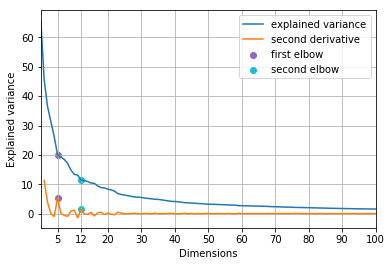

In [10]:
fig = plt.figure(figsize=(6,4))
acc = np.diff(pca_X.explained_variance_,2)
acc_i_sort = np.argsort(acc[1:])+1
print(acc_i_sort[-1]+1, acc[acc_i_sort[-1]])
print(acc_i_sort[-3]+1, acc[acc_i_sort[-3]])
plt.plot(range(len(pca_X.explained_variance_)),pca_X.explained_variance_, label='explained variance')
plt.plot(np.arange(len(pca_X.explained_variance_)-2)+1,np.diff(pca_X.explained_variance_,2), label='second derivative')
plt.scatter(acc_i_sort[-1]+1, acc[acc_i_sort[-1]], color='tab:purple')
plt.scatter(acc_i_sort[-3]+1, acc[acc_i_sort[-3]], color='tab:cyan')
plt.scatter(acc_i_sort[-1]+1, pca_X.explained_variance_[acc_i_sort[-1]+1], color='tab:purple',label = 'first elbow')
plt.scatter(acc_i_sort[-3]+1, pca_X.explained_variance_[acc_i_sort[-3]+1], color='tab:cyan',label = 'second elbow')
plt.xticks(list(range(20, 101, 10))+[5,12])
plt.legend()
plt.grid()
plt.xlabel('Dimensions')
plt.ylabel('Explained variance')
plt.xlim(xmin=0,xmax=100)

In [15]:
dim = 12
new_X = pca_X.transform(X)[:,:dim]
print(new_X.shape)

(52682, 12)


In [16]:
small_coded = pd.DataFrame(new_X, columns=[str(i) for i in range(dim)])
small_coded = small_coded.join(images_flat[['scale_digit', 'scale_unit', 'nffa_category']].loc[(images_flat['scale_unit'] == 'μm') & \
                                     ( (images_flat['scale_digit'] == 1) | (images_flat['scale_digit'] == 2) )].reset_index())
print(small_coded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52682 entries, 0 to 52681
Data columns (total 16 columns):
0                52682 non-null float64
1                52682 non-null float64
2                52682 non-null float64
3                52682 non-null float64
4                52682 non-null float64
5                52682 non-null float64
6                52682 non-null float64
7                52682 non-null float64
8                52682 non-null float64
9                52682 non-null float64
10               52682 non-null float64
11               52682 non-null float64
index            52682 non-null int64
scale_digit      52682 non-null float64
scale_unit       52682 non-null object
nffa_category    52682 non-null int64
dtypes: float64(13), int64(2), object(1)
memory usage: 6.4+ MB
None


In [17]:
start = time()
Z = linkage(small_coded[[str(i) for i in range(dim)]], 'ward')
stop = time()
print("Linkage computed in", stop - start, "seconds")

Linkage computed in 101.10312509536743 seconds


In [18]:
k_range = np.arange(2,300)
normalized_MI = np.zeros_like(k_range, dtype=float)
num_k = np.zeros_like(k_range)
for i,k in enumerate(k_range):
    clusters = fcluster(Z, k, criterion='maxclust')
    normalized_MI[i] = normalized_mutual_info_score(small_coded['nffa_category'].loc[small_coded['nffa_category']!=-1],\
                                                    clusters[small_coded['nffa_category']!=-1])
    num_k[i] = len(set(clusters))
    
i_sorted_MI = np.argsort(normalized_MI)    
i_max_MI = i_sorted_MI[-1]
clusters = fcluster(Z, k_range[i_max_MI], criterion='maxclust')
print("BEST MI:",normalized_MI[i_max_MI],"  with ", len(set(clusters)), " clusters.")

print()
### 2 peaks...
for i in i_sorted_MI[::-1]:
    if (k_range[i] < 50):
        break
i_lower_max_MI = i
clusters = fcluster(Z, k_range[i_lower_max_MI], criterion='maxclust')
print("Lower MI peak: ",normalized_MI[i_lower_max_MI]," with ", len(set(clusters)),\
      " clusters:\n", [(i, count) for i,count in zip(Counter(clusters).keys(), Counter(clusters).values())],"\n")


BEST MI: 0.3778763539729709   with  291  clusters.

Lower MI peak:  0.3404755578859073  with  39  clusters:
 [(31, 1307), (8, 801), (20, 829), (29, 1157), (10, 1739), (32, 2318), (13, 1007), (15, 1936), (5, 2524), (11, 689), (38, 791), (7, 1341), (12, 1674), (27, 2377), (30, 661), (18, 1865), (6, 265), (3, 794), (34, 947), (23, 2238), (4, 898), (19, 1725), (39, 1607), (21, 1076), (24, 2176), (28, 1759), (9, 1934), (26, 1349), (35, 993), (22, 985), (25, 938), (14, 1479), (33, 1111), (17, 1140), (36, 1808), (37, 992), (2, 1172), (1, 620), (16, 1660)] 



Text(0.5,1,'Mutual Information')

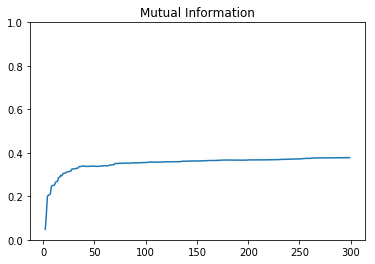

In [19]:
plt.plot(k_range, normalized_MI)
plt.ylim(0,1.0)
plt.title('Mutual Information')
# plt.plot(k_cl_1u, normalized_MI[k_cl_1u - 2], 'go')